<a href="https://colab.research.google.com/github/fahimku2020/fahimku2020/blob/main/Bert_text_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install wikipedia
!pip install nltk
!pip install torch
!pip install matplotlib
!pip install seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=29f4d0a264798965818a5924c095014a8c2e84ac075591234d280d6df6e23410
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


Enter Wikipedia topic to cluster: Computer science 

--- Semantic Clustering Results ---

Cluster 0 (Similarity: 0.8144):
Number of Sentences: 72
  1. fundamental concern computer science determining cannot automated.
  2. turing award generally recognized highest distinction computer science.
  3. history earliest foundations would become computer science predate invention modern digital computer.
  4. machines calculating fixed numerical tasks abacus existed since antiquity aiding computations multiplication division.
  5. algorithms performing computations existed since antiquity even development sophisticated computing equipment.
  6. wilhelm schickard designed constructed first working mechanical calculator
  7. gottfried leibniz demonstrated digital mechanical calculator called stepped reckoner.
  8. leibniz may considered first computer scientist information theorist various reasons including fact documented binary number system.
  9. thomas colmar launched mechanical calculator

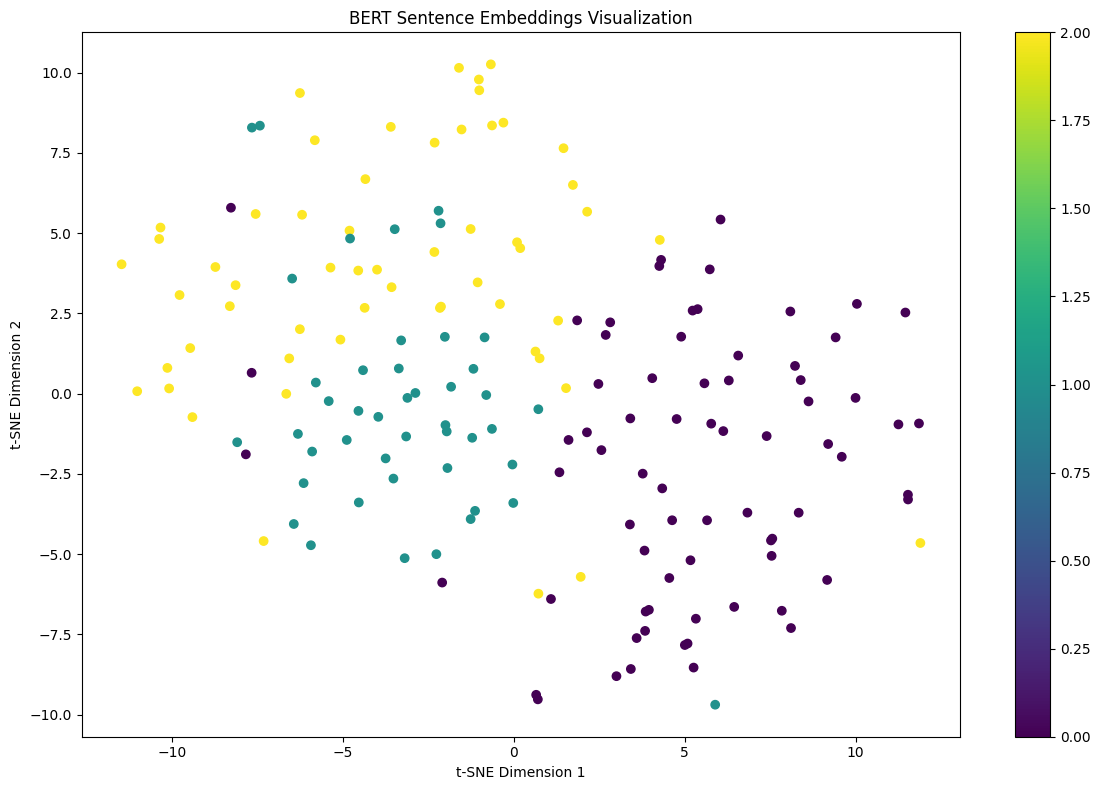

In [43]:
import re
import nltk
import numpy as np
import wikipedia
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

class BERTSemanticClustering:
    def __init__(self, num_clusters=5):
        # Download NLTK resources
        nltk.download('punkt_tab', quiet=True)
        nltk.download('stopwords', quiet=True)

        # Initialize BERT model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')

        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # Preprocessing parameters
        self.stop_words = set(stopwords.words('english'))
        self.num_clusters = num_clusters

    def fetch_wikipedia_content(self, topic):
        """Fetch Wikipedia article content"""
        try:
            page = wikipedia.page(topic)
            return page.content
        except Exception as e:
            print(f"Error fetching Wikipedia content: {e}")
            return None

    def preprocess_sentences(self, text):
        """Advanced text preprocessing"""
        # Lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z\s.]', '', text.lower())

        # Tokenize sentences
        sentences = sent_tokenize(text)

        # Filter sentences
        filtered_sentences = []
        for sentence in sentences:
            # Tokenize words
            words = sentence.split()

            # Remove stopwords and short words
            filtered_words = [
                word for word in words
                if word not in self.stop_words and len(word) > 2
            ]

            # Reconstruct sentence if not empty
            if filtered_words:
                filtered_sentences.append(' '.join(filtered_words))

        return filtered_sentences

    def get_bert_embeddings(self, sentences):
        """Generate BERT embeddings for sentences"""
        embeddings = []
        for sentence in sentences:
            # Tokenize and encode
            inputs = self.tokenizer(sentence, return_tensors='pt',
                                    max_length=512, truncation=True, padding=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Generate embeddings
            with torch.no_grad():
                outputs = self.model(**inputs)
                embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                embeddings.append(embedding.flatten())

        return np.array(embeddings)

    def cluster_sentences(self, embeddings):
        """Perform K-means clustering"""
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        return cluster_labels

    def extract_cluster_topics(self, sentences, cluster_labels):
        """Extract representative topic for each cluster"""
        clustered_sentences = {}
        for i in range(self.num_clusters):
            cluster_sentences = [
                sentences[j] for j in range(len(sentences))
                if cluster_labels[j] == i
            ]
            clustered_sentences[i] = cluster_sentences

        return clustered_sentences

    def calculate_cluster_similarity(self, embeddings, cluster_labels):
        """Calculate cluster similarity scores"""
        cluster_centers = {}
        for i in range(self.num_clusters):
            cluster_mask = cluster_labels == i
            cluster_center = np.mean(embeddings[cluster_mask], axis=0)
            cluster_centers[i] = cluster_center

        similarities = {}
        for cluster, center in cluster_centers.items():
            # Cosine similarity calculation
            similarities[cluster] = np.mean([
                np.dot(center, emb) / (np.linalg.norm(center) * np.linalg.norm(emb))
                for emb in embeddings[cluster_labels == cluster]
            ])

        return similarities

    def visualize_clusters(self, embeddings, cluster_labels):
        """Visualize clusters using t-SNE"""
        # Reduce dimensionality with t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        reduced_embeddings = tsne.fit_transform(embeddings)

        # Plot
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(
            reduced_embeddings[:, 0],
            reduced_embeddings[:, 1],
            c=cluster_labels,
            cmap='viridis'
        )
        plt.colorbar(scatter)
        plt.title('BERT Sentence Embeddings Visualization')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.tight_layout()
        plt.show()

    def process_document(self, topic):
        """Main processing method"""
        # Fetch and preprocess content
        content = self.fetch_wikipedia_content(topic)
        if not content:
            return

        # Preprocess sentences
        sentences = self.preprocess_sentences(content)

        # Generate BERT embeddings
        embeddings = self.get_bert_embeddings(sentences)

        # Cluster sentences
        cluster_labels = self.cluster_sentences(embeddings)

        # Extract clustered sentences
        clustered_sentences = self.extract_cluster_topics(sentences, cluster_labels)

        # Calculate cluster similarities
        similarities = self.calculate_cluster_similarity(embeddings, cluster_labels)

        # Print cluster details
        print("\n--- Semantic Clustering Results ---")
        for cluster, sentences in clustered_sentences.items():
            print(f"\nCluster {cluster} (Similarity: {similarities[cluster]:.4f}):")
            print(f"Number of Sentences: {len(sentences)}")
            for i, sentence in enumerate(sentences[:10], 1):
                print(f"  {i}. {sentence}")

        # Visualize clusters
        self.visualize_clusters(embeddings, cluster_labels)

def main():
    # Create clustering instance
    clustering = BERTSemanticClustering(num_clusters=3)

    # Get user input
    topic = input("Enter Wikipedia topic to cluster: ")

    # Process document
    clustering.process_document(topic)

if __name__ == "__main__":
    main()

Enter Wikipedia topic: Computer science 
Enter similarity threshold (0.0 - 1.0): 0.7


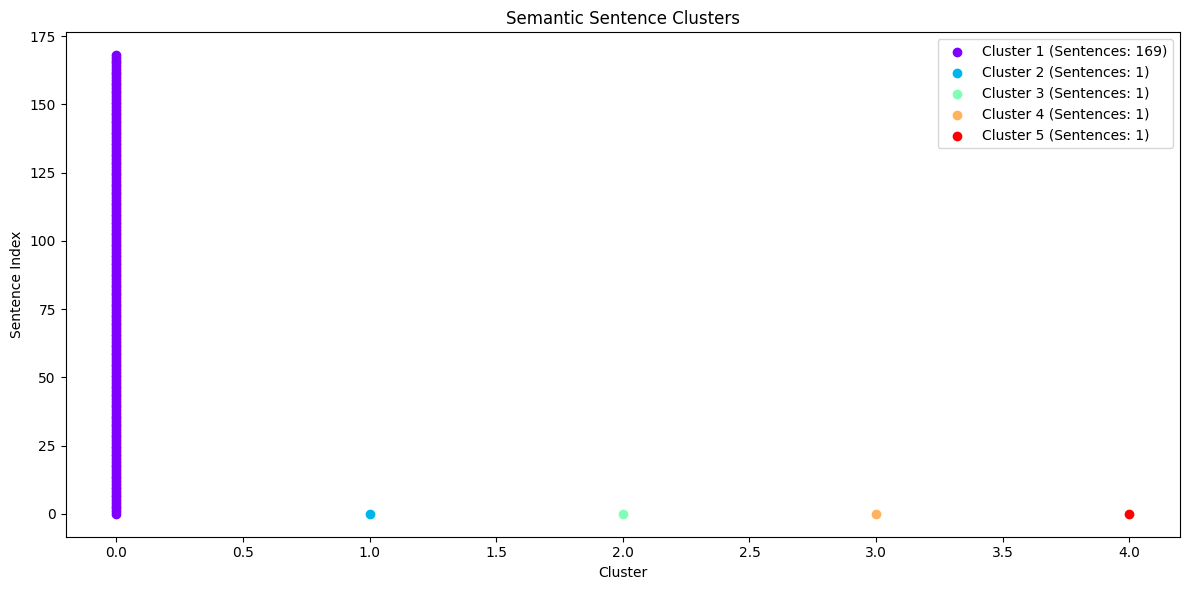


--- Semantic Clustering Results ---

Cluster 1 (Sentences: 169):
- computer science study computation information automation.
- computer science spans theoretical disciplines algorithms theory computation information theory applied disciplines including design implementation hardware software.
- algorithms data structures central computer science.

Cluster 2 (Sentences: 1):
- machine finished hailed babbages dream come true.

Cluster 3 (Sentences: 1):
- several alternative names proposed.

Cluster 4 (Sentences: 1):
- term used mainly scandinavian countries.

Cluster 5 (Sentences: 1):
- industrial use tool support required.

Document Diversity Score: 0.1420
Execution Time: 18.64 seconds


In [42]:
import re
import time
import numpy as np
import wikipedia
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
from typing import List, Dict

class BERTSemanticClustering:
    def __init__(self):
        # Download NLTK resources
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)

        # Initialize BERT model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')

        # Advanced stopwords and preprocessing
        self.stop_words = set(stopwords.words('english'))
        custom_stopwords = {
            'furthermore', 'however', 'additionally', 'nonetheless',
            'moreover', 'consequently', 'subsequently', 'alternatively'
        }
        self.stop_words.update(custom_stopwords)

    def fetch_wikipedia_content(self, topic: str) -> str:
        """Fetch Wikipedia article content"""
        try:
            page = wikipedia.page(topic)
            return page.content
        except Exception as e:
            print(f"Error fetching content: {e}")
            return ""

    def preprocess_text(self, text: str) -> List[str]:
        """Advanced text preprocessing"""
        # Lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z\s.]', '', text.lower())

        # Tokenize sentences
        sentences = sent_tokenize(text)

        # Advanced filtering
        filtered_sentences = []
        for sentence in sentences:
            # Tokenize words
            words = sentence.split()

            # Remove stopwords and short words
            filtered_words = [
                word for word in words
                if (word not in self.stop_words and len(word) > 2)
            ]

            # Reconstruct sentence if not empty
            if filtered_words:
                filtered_sentences.append(' '.join(filtered_words))

        return filtered_sentences

    def get_bert_embeddings(self, sentences: List[str]) -> np.ndarray:
        """Generate BERT embeddings for sentences"""
        embeddings = []

        with torch.no_grad():
            for sentence in sentences:
                # Tokenize and encode
                inputs = self.tokenizer(
                    sentence,
                    return_tensors='pt',
                    max_length=512,
                    truncation=True
                )

                # Get BERT embeddings
                outputs = self.model(**inputs)
                embedding = outputs.last_hidden_state.mean(dim=1).numpy()
                embeddings.append(embedding[0])

        return np.array(embeddings)

    def compute_sentence_similarities(self, embeddings: np.ndarray) -> np.ndarray:
        """Compute cosine similarities between sentence embeddings"""
        return cosine_similarity(embeddings)

    def cluster_sentences(self, sentences: List[str], similarity_threshold: float = 0.7) -> Dict:
        """Cluster sentences based on semantic similarity"""
        # Get BERT embeddings
        embeddings = self.get_bert_embeddings(sentences)

        # Compute similarities
        similarity_matrix = self.compute_sentence_similarities(embeddings)

        # Create graph for clustering
        G = nx.Graph()
        for i in range(len(sentences)):
            G.add_node(i, sentence=sentences[i])

        # Add edges based on similarity
        for i in range(len(sentences)):
            for j in range(i+1, len(sentences)):
                if similarity_matrix[i, j] >= similarity_threshold:
                    G.add_edge(i, j)

        # Find connected components (clusters)
        clusters = list(nx.connected_components(G))

        # Organize clusters
        clustered_sentences = {}
        for idx, cluster in enumerate(clusters):
            cluster_sentences = [sentences[node] for node in cluster]
            clustered_sentences[f'Cluster {idx+1}'] = cluster_sentences

        return clustered_sentences

    def calculate_document_diversity(self, clusters: Dict) -> float:
        """Calculate document diversity score"""
        total_sentences = sum(len(cluster) for cluster in clusters.values())
        num_clusters = len(clusters)

        # Entropy-based diversity score
        cluster_sizes = [len(cluster)/total_sentences for cluster in clusters.values()]
        diversity_score = -sum(p * np.log(p) for p in cluster_sizes if p > 0)

        return diversity_score

    def visualize_clusters(self, clusters: Dict):
        """Visualize clusters and their relationships"""
        plt.figure(figsize=(12, 6))

        # Create color map
        colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

        for i, (cluster_name, sentences) in enumerate(clusters.items()):
            plt.scatter(
                [i]*len(sentences),
                range(len(sentences)),
                label=f'{cluster_name} (Sentences: {len(sentences)})',
                color=colors[i]
            )

        plt.title('Semantic Sentence Clusters')
        plt.xlabel('Cluster')
        plt.ylabel('Sentence Index')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

    def process_document(self, topic: str, similarity_threshold: float = 0.7):
        """Main processing method"""
        start_time = time.time()

        # Fetch and preprocess content
        content = self.fetch_wikipedia_content(topic)
        sentences = self.preprocess_text(content)

        # Cluster sentences
        clusters = self.cluster_sentences(sentences, similarity_threshold)

        # Calculate diversity score
        diversity_score = self.calculate_document_diversity(clusters)

        # Visualize clusters
        self.visualize_clusters(clusters)

        # Print results
        print("\n--- Semantic Clustering Results ---")
        for cluster_name, cluster_sentences in clusters.items():
            print(f"\n{cluster_name} (Sentences: {len(cluster_sentences)}):")
            for sentence in cluster_sentences[:3]:  # Print first 3 sentences per cluster
                print(f"- {sentence}")

        print(f"\nDocument Diversity Score: {diversity_score:.4f}")
        print(f"Execution Time: {time.time() - start_time:.2f} seconds")

        return clusters

def main():
    # Create clustering instance
    clustering = BERTSemanticClustering()

    # Get user inputs
    topic = input("Enter Wikipedia topic: ")
    similarity_threshold = float(input("Enter similarity threshold (0.0 - 1.0): "))

    # Process document
    clustering.process_document(topic, similarity_threshold)

if __name__ == "__main__":
    main()

In [38]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00
